In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import netgraph
import seaborn as sns

MEDIUM_SIZE = 20
SMALL_SIZE = 0.75 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


def build_network(G):
    A = nx.to_numpy_array(G).astype(np.float64)
    n = A.shape[0]

    d = A.sum(0)

    for i in range(n):
        A[i, i] = 0
        for j in range(i):
            if A[i, j] != 0:
                A[i, j] = 1.0 / max(d[i], d[j])
                A[j, i] = A[i, j]
    
    for i in range(n):
        A[i, i] = 1 - A[i, :].sum()

    return A, n

def likelihood(s, theta):
    return theta**s * (1 - theta)**(1 - s)

def log_likelihood(s, theta):
    return s * np.log(theta) + (1 - s) * np.log(1 - theta)

def log_likelihood_sensitivity(Theta):
    return max([abs(np.log(theta / (1 - theta))) for theta in Theta])

def kl_divergence(p, q):
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

def calculate_sensitivity(Theta, A, n, network_dp):
    Delta_likelihood = log_likelihood_sensitivity(Theta)

    A_max = np.max(A * (1 - np.eye(n)))

    if network_dp:
        Delta = max(Delta_likelihood, A_max)
    else:
        Delta = Delta_likelihood

    return Delta

def belief_exchange(A, n, T, K, eps, Delta, Theta, theta_star, number_of_samples, setting='MLE'):
    if setting == 'MLE':
        S = (np.random.uniform(0, 1, n) <= theta_star).astype(np.float64)
        A_prime = A + np.eye(n)
    elif setting == 'OL':
        S = (np.random.uniform(0, 1, size=(T, n)) <= theta_star).astype(np.float64)
        A_prime = A

    mu = np.ones((T, n, len(Theta)))


    for t in range(T):
        for i in range(n):
            for theta in range(len(Theta)):
                if t == 0:
                    if setting == 'MLE':
                        mu[0, i, theta] = np.exp(number_of_samples[i, 0] * log_likelihood(S[i], Theta[theta]))
                    elif setting == 'OL':
                        mu[0, i, theta] = np.exp(number_of_samples[i, 0] *  log_likelihood(S[0, i], Theta[theta]))
                else:
                    if setting == 'MLE':
                        mu[t, i, theta] = np.exp(np.dot(A_prime[i, :], np.log(mu[t - 1, :, theta])))
                    elif setting == 'OL':
                        mu[t, i, theta] = np.exp(np.dot(A_prime[i, :], np.log(mu[t - 1, :, theta])) * np.exp(number_of_samples[i, t] * log_likelihood(S[t, i], Theta[theta])))

                mu[t, i, :] /= mu[t, i, :].sum()

        if np.all(np.isnan(mu[t])):
            mu[t] = mu[t - 1]


    nu = np.ones((K, T, n, len(Theta)))

    if setting == 'MLE':
        max_num_samples = number_of_samples[:, 0]
    elif setting == 'OL':
        max_num_samples = number_of_samples.max(1)

    for k in range(K):
        for t in range(T):
            for i in range(n):
                for theta in range(len(Theta)):
                    if t == 0:
                        if setting == 'MLE':
                            nu[k, 0, i, theta] = np.exp(number_of_samples[i, 0] * log_likelihood(S[i], Theta[theta]) + np.random.laplace(loc=0, scale=max_num_samples[i] * Delta/eps))
                        elif setting == 'OL':
                            nu[k, 0, i, theta] = np.exp(number_of_samples[i, 0] * log_likelihood(S[0, i], Theta[theta]) + np.random.laplace(loc=0, scale=max_num_samples[i] * Delta/eps))
                    else:
                        if setting == 'MLE':
                            nu[k, t, i, theta] = np.exp(np.dot(A_prime[i, :], np.log(nu[k, t - 1, :, theta])))
                        elif setting == 'OL':
                            nu[k, t, i, theta] = np.exp(np.dot(A_prime[i, :], np.log(nu[k, t - 1, :, theta])) + number_of_samples[i, t] * log_likelihood(S[t, i], Theta[theta]) + np.random.laplace(loc=0, scale=max_num_samples[i] * Delta/eps))

                nu[k, t, i, :] /= nu[k, t, i, :].sum()

            if np.all(np.isnan(nu[k, t])):
                nu[k, t] = nu[k, t - 1]

    return mu, nu

def aggregate_mle_beliefs(nu, counter_threshold=0.5):

    nu_AM = np.mean(nu, 0)
    nu_GM = np.exp(np.mean(np.log(nu), 0))

    N_counters = (nu >= counter_threshold).astype(np.float64).mean(0)

    return nu_AM, nu_GM, N_counters



def plot_beliefs_graph(G, A, beliefs, titles, theta_star_index, suptitle='', outfile=None, node_layout='circular'):
        
    fig, ax = plt.subplots(1, len(beliefs), figsize=(5 * len(beliefs), 5))

    cmap = plt.cm.get_cmap('Reds')

    for i, belief in enumerate(beliefs):

        
        node_color = {i: cmap(belief[-1, i, theta_star_index]) for i in range(n)}
        edge_color = {(i, j): cmap(A[i, j]) for i, j in G.edges()}

        node_labels = {i: f'{i + 1}\n({belief[-1, i, theta_star_index]:.2f})' for i in range(n)}
        node_label_fontdict=dict(color=cmap(0.2), weight='bold')

        netgraph.Graph(G, ax=ax[i], node_size=10, edge_width=1.5, node_labels=node_labels, node_label_fontdict=node_label_fontdict, node_color=node_color, edge_color=edge_color, node_layout=node_layout)

        plt.Normalize(vmin=0, vmax=1)

        ax[i].set_title(titles[i], fontsize=MEDIUM_SIZE)


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    fig.suptitle(suptitle)

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_8667/379670843.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_8667/379670843.py:157: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_8667/379670843.py:137: MatplotlibD

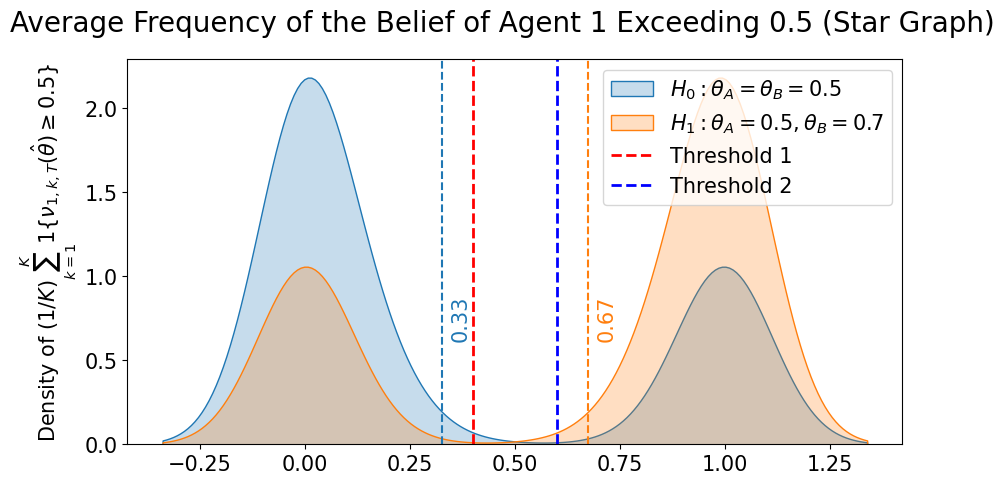

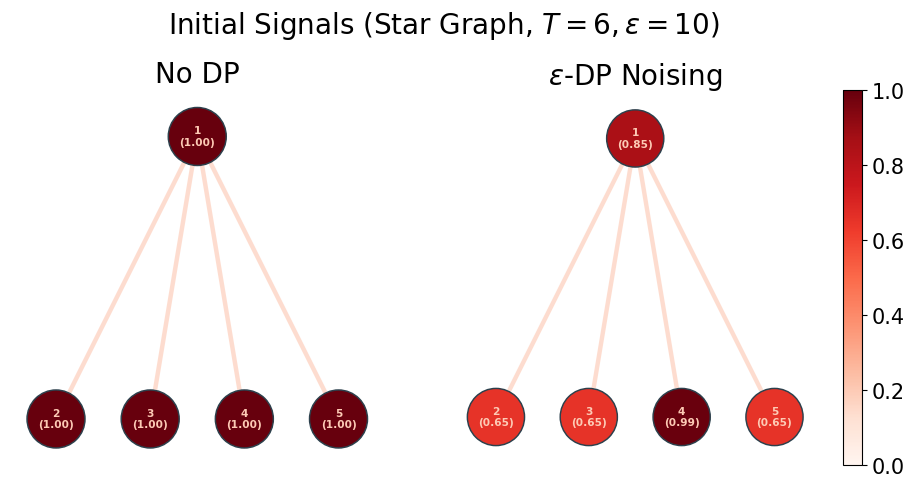

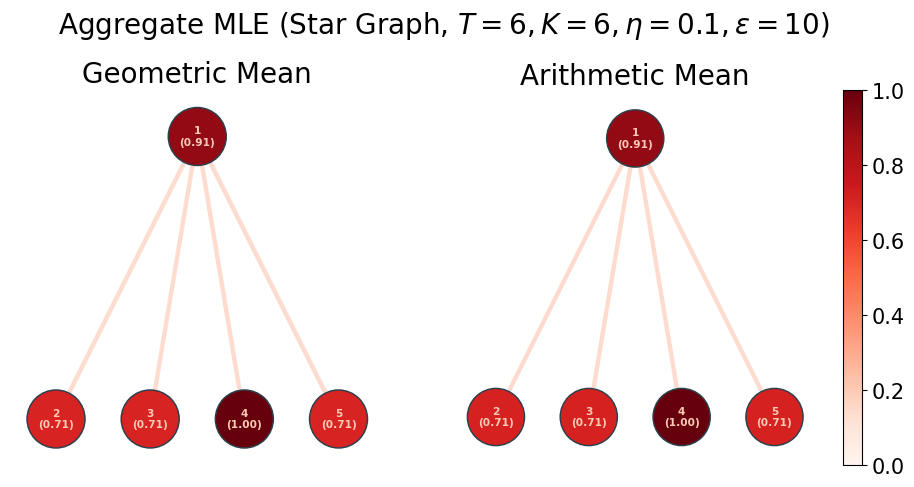

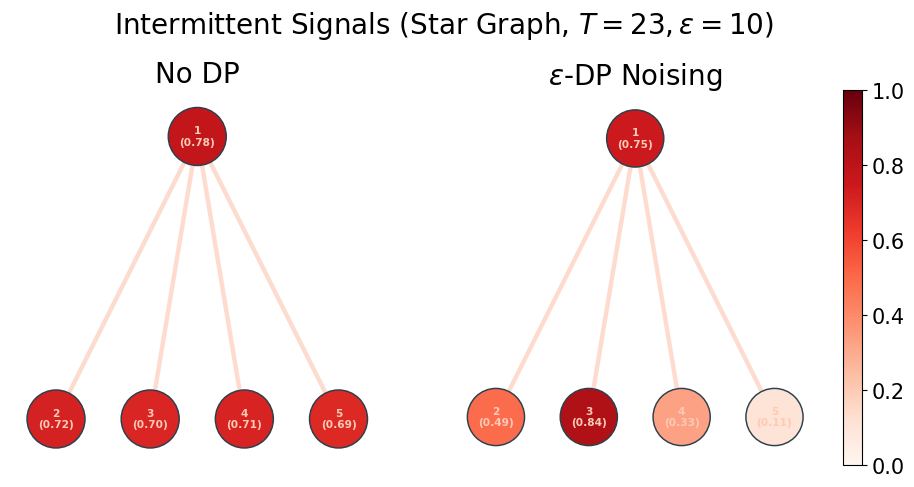

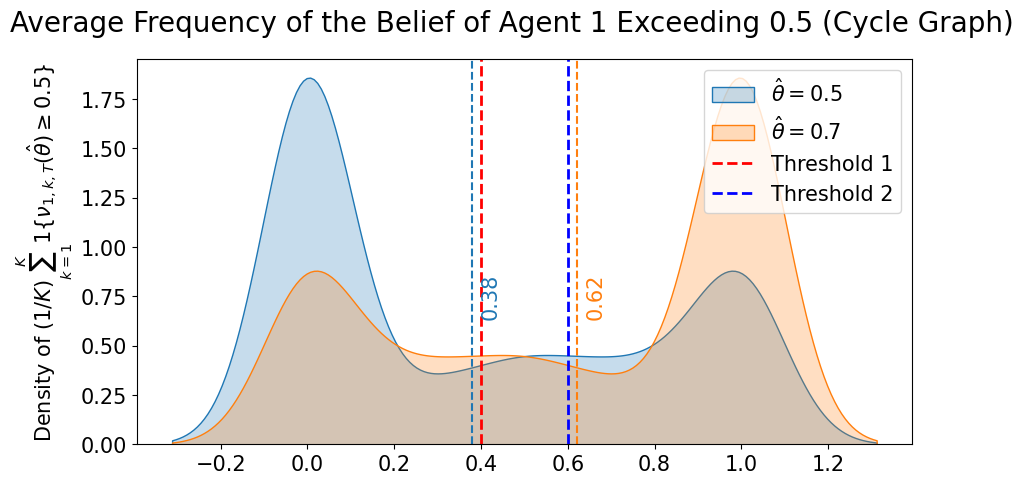

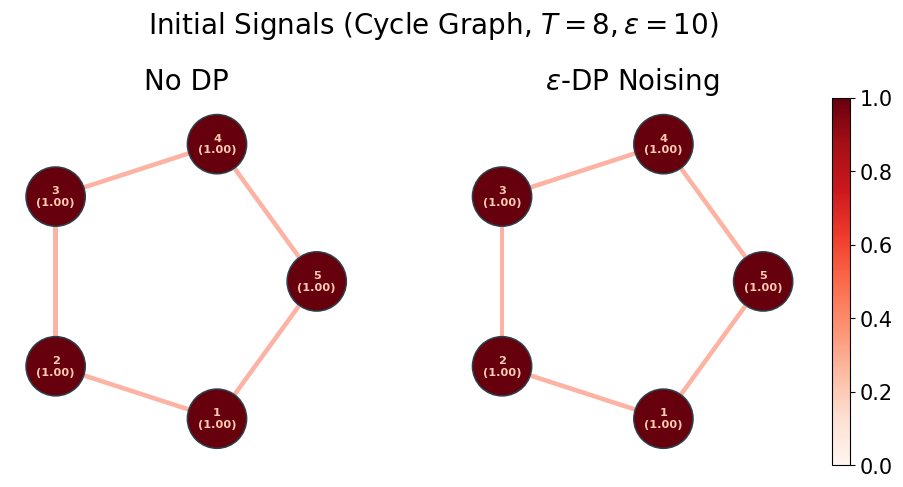

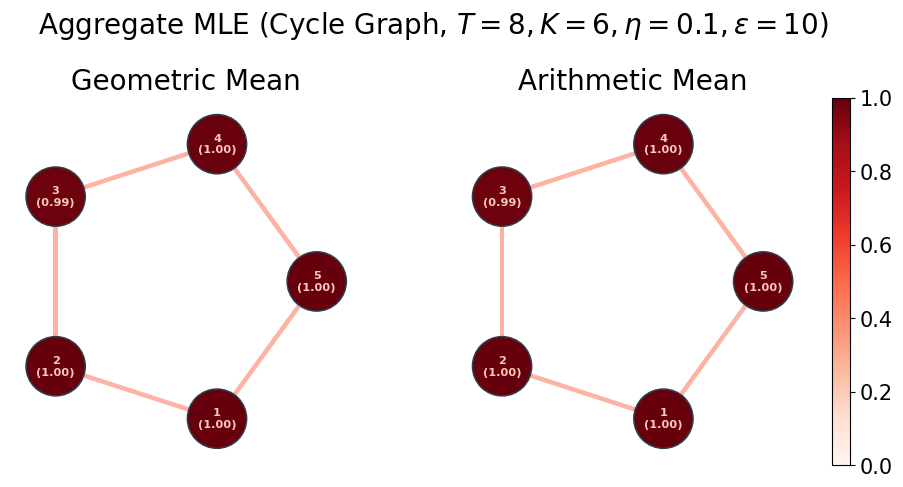

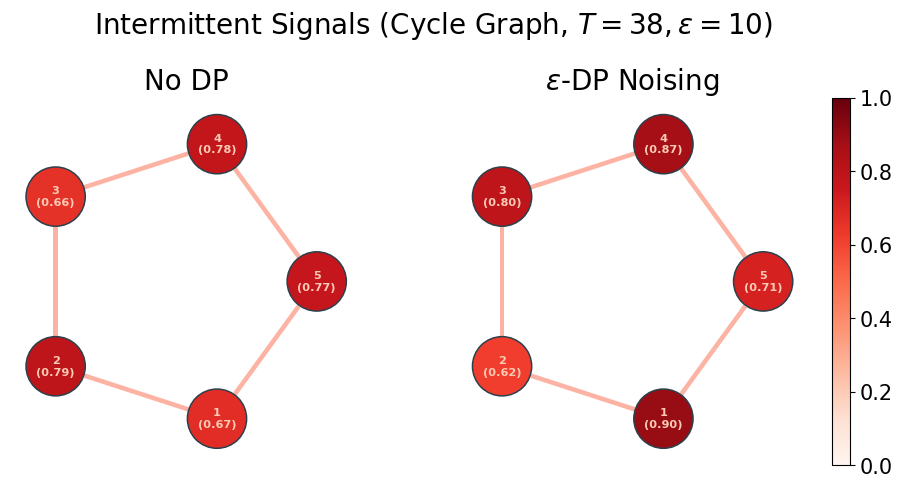

In [2]:
# Example
np.random.seed(10)
eps_gap = 0.4
p_pop = 0.1
n_pop = 10

Theta = np.array([1/2, 1/2 + eps_gap / 2])

names = {
    1/2 : '$H_0 : \\theta_A = \\theta_B = 0.5$',
    1/2 + eps_gap / 2 : f'$H_1 : \\theta_A = 0.5, \\theta_B = {1/2 + eps_gap/2}$'
}

theta_star_index = 1
theta_star = Theta[theta_star_index]

network_dp = False

Delta = log_likelihood_sensitivity(Theta)

n = 4

G  = nx.star_graph(n)
A, n = build_network(G)

Delta = calculate_sensitivity(Theta, A, n, network_dp=network_dp)

eta = 0.1
l_n_Theta = 2 * n * eps_gap**2
Gamma_n_theta = max([abs(log_likelihood(s, theta)) for s in [0, 1] for theta in Theta])
eps = 10

kl_div_samples = []

for i in range(1000):
    s = float(np.random.uniform() <= Theta[0])

    log_likelihood_0 = log_likelihood(s, Theta[0])
    log_likelihood_1 = log_likelihood(s, Theta[1])

    kl_div_samples.append(log_likelihood_0 - log_likelihood_1)

Q_n_theta = np.std(kl_div_samples)

# Graph
eigvals = np.linalg.eigvalsh(A)
beta_star_n = 1 - eigvals[-2]

eigvals = np.linalg.eigvalsh(A + np.eye(n))
alpha_star_n = 1/2 * max(eigvals[1], abs(eigvals[-1]))


# Runtime
T_ol = int(np.ceil(np.sqrt(max(np.sqrt(n * np.log(len(Theta))/l_n_Theta), n**2 * len(Theta) * (Q_n_theta + Delta / eps) * (n_pop * p_pop + np.sqrt(n * p_pop * (1 - p_pop) / eta)) / (l_n_Theta * eta * (1 - beta_star_n**2))))))
K_mle = int(np.ceil(len(Theta) * np.log(len(Theta) / eta)))
K_ol = 1

number_of_samples = np.random.binomial(n_pop, p_pop, size=(n, T_ol))

T_mle = int(np.ceil(np.log(1 / eta) * (np.log (1 / eta) + np.log(n * number_of_samples[:, 0].max() / (eps_gap * eps)))))


mu_MLE, nu_MLE = belief_exchange(A, n, T_mle, K_mle, eps, Delta, Theta, theta_star, number_of_samples, setting='MLE')

nu_AM, nu_GM, _ = aggregate_mle_beliefs(nu_MLE)

N_counters = []

for i in range(1000):
    _, nu_MLE = belief_exchange(A, n, T_mle, K_mle, eps, Delta, Theta, theta_star, number_of_samples, setting='MLE')
    _, _, N_counter = aggregate_mle_beliefs(nu_MLE, counter_threshold=0.5)
    N_counters.append(N_counter[-1])

N_counters = np.array(N_counters)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, theta in enumerate(Theta):
    sns.kdeplot(N_counters[:, 0, i], ax=ax, fill=True, label=names[theta])
    
    # Draw vertical line at mean
    ax.axvline(N_counters[:, 0, i].mean(), color=sns.color_palette()[i], linestyle='--')
    ax.text(N_counters[:, 0, i].mean() + 0.02, 0.75, f'{N_counters[:, 0, i].mean():.2f}', rotation=90, verticalalignment='center', horizontalalignment='left', color=sns.color_palette()[i])

ax.axvline(0.4, color='red', linestyle='--', linewidth=2, label='Threshold 1')
ax.axvline(0.6, color='blue', linestyle='--', linewidth=2, label='Threshold 2')
ax.set_ylabel('Density of $(1/K) \sum_{k = 1}^K 1 \\{ \\nu_{1, k, T} (\\hat \\theta) \geq 0.5 \\}$')
ax.legend()
fig.suptitle('Average Frequency of the Belief of Agent 1 Exceeding 0.5 (Star Graph)')

fig.savefig('figures/agent1_frequency_star.pdf')

plot_beliefs_graph(G, A, [mu_MLE, nu_MLE[0]], ['No DP', '$\\varepsilon$-DP Noising'], theta_star_index, suptitle=f'Initial Signals (Star Graph, $T = {T_mle}, \\varepsilon = {eps}$)', outfile='figures/mle_star.pdf', node_layout='dot')
plot_beliefs_graph(G, A, [nu_GM, nu_AM], ['Geometric Mean', 'Arithmetic Mean'], theta_star_index, suptitle=f'Aggregate MLE (Star Graph, $T = {T_mle}, K = {K_mle}, \\eta = {eta}, \\varepsilon = {eps}$)', outfile='figures/aggregate_mle_star.pdf', node_layout='dot')

mu_OL, nu_OL = belief_exchange(A, n, T_ol, K_ol, eps, Delta, Theta, theta_star, number_of_samples, setting='OL')

plot_beliefs_graph(G, A, [mu_OL, nu_OL[0]], ['No DP', '$\\varepsilon$-DP Noising'], theta_star_index, suptitle=f'Intermittent Signals (Star Graph, $T = {T_ol}, \\varepsilon = {eps}$)', outfile='figures/ol_star.pdf', node_layout='dot')


G  = nx.cycle_graph(n)
A, n = build_network(G)

Delta = calculate_sensitivity(Theta, A, n, network_dp=network_dp)

# Graph
eigvals = np.linalg.eigvalsh(A)
beta_star_n = max(eigvals[-2], abs(eigvals[0]))

eigvals = np.linalg.eigvalsh(A + np.eye(n))
alpha_star_n = 1/2 * max(eigvals[-2], abs(eigvals[0]))


# Runtime
T_ol = int(np.ceil(np.sqrt(max(np.sqrt(n * np.log(len(Theta))/l_n_Theta), n**2 * len(Theta) * (Q_n_theta + Delta / eps) * (n_pop * p_pop + np.sqrt(n * p_pop * (1 - p_pop) / eta)) / (l_n_Theta * eta * (1 - beta_star_n**2))))))
K_mle = int(np.ceil(len(Theta) * np.log(len(Theta) / eta)))
K_ol = 1

number_of_samples = np.random.binomial(n_pop, p_pop, size=(n, T_ol))

T_mle = int(np.ceil(np.log(1 / eta) * (np.log (1 / eta) + np.log(n * number_of_samples[:, 0].max() / (eps_gap * eps)))))

mu_MLE, nu_MLE = belief_exchange(A, n, T_mle, K_mle, eps, Delta, Theta, theta_star, number_of_samples, setting='MLE')

nu_AM, nu_GM, _ = aggregate_mle_beliefs(nu_MLE)


N_counters = []

for i in range(1000):
    _, nu_MLE = belief_exchange(A, n, T_mle, K_mle, eps, Delta, Theta, theta_star, number_of_samples, setting='MLE')
    _, _, N_counter = aggregate_mle_beliefs(nu_MLE, counter_threshold=0.5)
    N_counters.append(N_counter[-1])

N_counters = np.array(N_counters)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, theta in enumerate(Theta):
    sns.kdeplot(N_counters[:, 0, i], ax=ax, fill=True, label=f'$\\hat \\theta = {theta}$')
    
    # Draw vertical line at mean
    ax.axvline(N_counters[:, 0, i].mean(), color=sns.color_palette()[i], linestyle='--')
    ax.text(N_counters[:, 0, i].mean() + 0.02, 0.75, f'{N_counters[:, 0, i].mean():.2f}', rotation=90, verticalalignment='center', horizontalalignment='left', color=sns.color_palette()[i])

ax.axvline(0.4, color='red', linestyle='--', linewidth=2, label='Threshold 1')
ax.axvline(0.6, color='blue', linestyle='--', linewidth=2, label='Threshold 2')
ax.set_ylabel('Density of $(1/K) \sum_{k = 1}^K 1 \\{ \\nu_{1, k, T} (\\hat \\theta) \geq 0.5 \\}$')
ax.legend()
fig.suptitle('Average Frequency of the Belief of Agent 1 Exceeding 0.5 (Cycle Graph)')

fig.savefig('figures/agent1_frequency_cycle.pdf')


plot_beliefs_graph(G, A, [mu_MLE, nu_MLE[0]], ['No DP', '$\\varepsilon$-DP Noising'], theta_star_index, suptitle=f'Initial Signals (Cycle Graph, $T = {T_mle}, \\varepsilon = {eps}$)', outfile='figures/mle_cycle.pdf')
plot_beliefs_graph(G, A, [nu_GM, nu_AM], ['Geometric Mean', 'Arithmetic Mean'], theta_star_index, suptitle=f'Aggregate MLE (Cycle Graph, $T = {T_mle}, K = {K_mle}, \\eta = {eta}, \\varepsilon = {eps}$)', outfile='figures/aggregate_mle_cycle.pdf')

mu_OL, nu_OL = belief_exchange(A, n, T_ol, K_ol, eps, Delta, Theta, theta_star, number_of_samples, setting='OL')

plot_beliefs_graph(G, A, [mu_OL, nu_OL[0]], ['No DP', '$\\varepsilon$-DP Noising'], theta_star_index, suptitle=f'Intermittent Signals (Cycle Graph, $T = {T_ol}, \\varepsilon = {eps}$)', outfile='figures/ol_cycle.pdf')